In [491]:
import sys
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
import datasets
import pandas as pd
import numpy as np
import roc_auc
import estimator_knn as knn
import estimator_rssibased as rssie
import json

In [233]:
# data loader
ds = datasets.load('data/raw/0[12]_[01][123]_0[1234]*_*')

path = data/raw/0[12]_[01][123]_0[1234]*_*
data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
..............................
data/raw/01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅
...x..........................
data/raw/01_01_03_4F実験室_XperiaZ3_胸ポケット_裏上_正常_5秒後まっすぐ帰宅
.........................x....
data/raw/01_01_04_4F実験室_XperiaZ3_カバン_裏上_正常_5秒後まっすぐ帰宅
.....................x........
data/raw/01_02_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ外出
..............................
data/raw/01_02_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ外出
..............................
data/raw/01_02_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ外出
..............................
data/raw/01_03_01_4F実験室_XperiaZ3_胸ポケット_裏上_異常_まっすぐ帰宅
..............................
data/raw/01_03_02_4F実験室_XperiaZ3_ズボン_裏上_異常_まっすぐ帰宅
..............................
data/raw/01_03_03_4F実験室_XperiaZ3_カバン_裏上_異常_まっすぐ帰宅
..............................
data/raw/01_11_01_エネマネハウス_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
..............................
data/raw/01_11_02_エネマネハウス_XperiaZ3_カバン_裏上_正常_まっす

In [ ]:
def knn_combinations

1
3


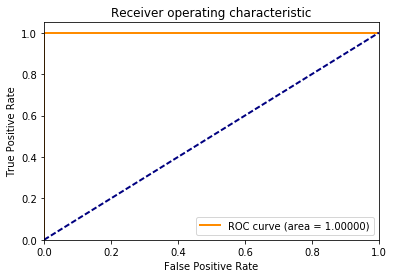

auc 1.00000
{'ma_window': 1, 'ms_interval': 20, 'auc': 1.0, 'n_record': 1, 'n_neighbors': 1, 'type': 'kNN', 'n_train': 1, 'algorithm': 'ball_tree', 'sensor_type': ['rssi.a', 'rssi.b']}


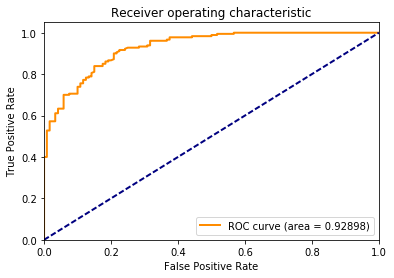

auc 0.92898
{'ma_window': 1, 'ms_interval': 20, 'auc': 0.92898148148148152, 'n_record': 1, 'n_neighbors': 3, 'type': 'kNN', 'n_train': 1, 'algorithm': 'ball_tree', 'sensor_type': ['rssi.a', 'rssi.b']}


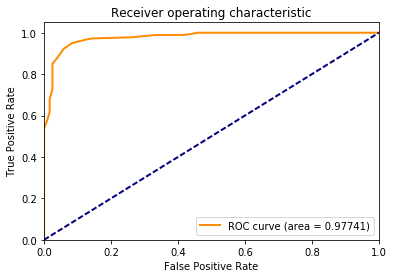

auc 0.97741
{'ma_window': 1, 'ms_interval': 20, 'auc': 0.97740740740740739, 'n_record': 1, 'type': 'rssi_based', 'n_train': 1, 'sensor_type': ['rssi.a', 'rssi.b']}


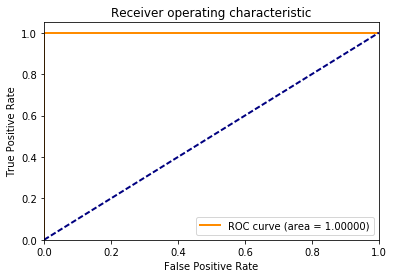

auc 1.00000
{'ma_window': 1, 'ms_interval': 20, 'auc': 1.0, 'n_record': 1, 'n_neighbors': 1, 'type': 'kNN', 'n_train': 1, 'algorithm': 'ball_tree', 'sensor_type': [['linear_accel[0]', 'linear_accel[1]', 'linear_accel[2]']]}


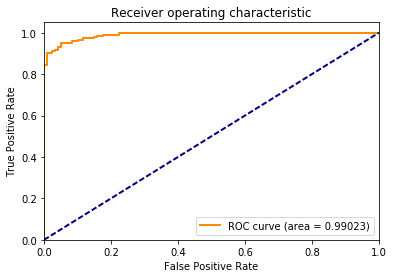

auc 0.99023
{'ma_window': 1, 'ms_interval': 20, 'auc': 0.99023148148148155, 'n_record': 1, 'n_neighbors': 3, 'type': 'kNN', 'n_train': 1, 'algorithm': 'ball_tree', 'sensor_type': [['linear_accel[0]', 'linear_accel[1]', 'linear_accel[2]']]}


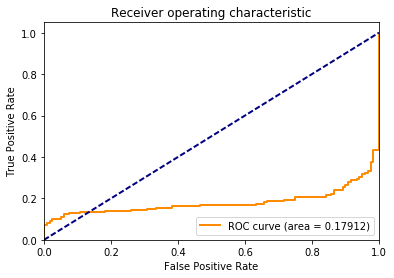

auc 0.17912
{'ma_window': 1, 'ms_interval': 20, 'auc': 0.17912037037037037, 'n_record': 1, 'type': 'rssi_based', 'n_train': 1, 'sensor_type': [['linear_accel[0]', 'linear_accel[1]', 'linear_accel[2]']]}


,algorithm,auc,ma_window,ms_interval,n_neighbors,n_record,n_train,sensor_type,type
0,ball_tree,1.000000,1,20,1.0,1,1,"[rssi.a, rssi.b]",kNN
1,ball_tree,0.928981,1,20,3.0,1,1,"[rssi.a, rssi.b]",kNN
2,NaN,0.977407,1,20,NaN,1,1,"[rssi.a, rssi.b]",rssi_based
3,ball_tree,1.000000,1,20,1.0,1,1,"[[linear_accel[0], linear_accel[1], linear_acc...",kNN
4,ball_tree,0.990231,1,20,3.0,1,1,"[[linear_accel[0], linear_accel[1], linear_acc...",kNN
5,NaN,0.179120,1,20,NaN,1,1,"[[linear_accel[0], linear_accel[1], linear_acc...",rssi_based


In [492]:
# grid search implementation (under test)
def test():
    # knn parameters
    range_n_neighbors = np.arange(1, 5, 2)
    
    # create estimator list
    models = []
    mesh_data = np.meshgrid(range_n_neighbors)
    for n_neighbors, in zip(mesh_data[0].ravel()):
        models.append(knn.EstimatorKNN(n_neighbors=n_neighbors))
    models.append(rssie.EstimatorRssiBased())
    
    # other  parameters
    sensor_type_master = [
        ['rssi.a', 'rssi.b'],
        [['linear_accel[0]', 'linear_accel[1]', 'linear_accel[2]']]
    ]
    range_n_record = np.arange(1, 10, 10)
    range_n_train = np.arange(1, 20, 20)
    range_ms_interval = np.array([20, 40, 100])
    range_ma_window = np.arange(1, 4, 4)
    range_sensor_type = sensor_type_master # to be combinationable
    
    mesh_data = np.meshgrid(range_n_record, range_n_train,
                            range_ms_interval, range_ma_window, range_sensor_type)

    # create grid test case
    test_case = []
    for n_record, n_train, ms_interval, ma_window, sensor_type in zip(mesh_data[0].ravel(), mesh_data[1].ravel(), mesh_data[2].ravel(),
               mesh_data[3].ravel(), mesh_data[4].ravel()):
        
        # save test case and result
        _t = {'n_record': n_record, 'n_train': n_train,
                     'ms_interval': ms_interval, 'ma_window': ma_window, 'sensor_type': sensor_type}
        test_case.append(_t)

    # remove unavailable test case
    df = pd.DataFrame(test_case)
    #df = df[~((df.neighbor == 3) & (df['sample'] == 10))]
    
    # limit test case for test
    df = df[:2]
    
    # set the data title
    base = '01_11_01'
    normal = '^01_11'
    anomaly = '^01_1[23]'
    
    # execute test
    record = []
    #auc_list = []
    for k, t in df.iterrows():
        for m in models:
            auc = eval_estimator(m, base=base, normal=normal, anomaly=anomaly,
                                 n_train=t['n_train'], sensor_type=t['sensor_type'], n_record=t['n_record'],
                                 ms_interval=t['ms_interval'], ma_window=t['ma_window'])
            d = t.to_dict()
            d.update(m.get_params())
            d.update({'auc': auc, 'type': m.get_type()})
            print(d)
            record.append(d)

    # output as csv
    df = pd.DataFrame.from_records(record)
    df.to_csv('test_record.csv')
    
    return df

test()

In [453]:
def read_csv():
    f = lambda x : json.loads(x.replace("'","\""))
    df = pd.read_csv('test_record.csv', converters={'sensor_type': f}, index_col=0)
    return df
#read_csv()

,ma_window,ms_interval,n_neighbor,n_record,n_train,sensor_type,auc
0,1,20,1,1,1,"[rssi.a, rssi.b]",0.928981
1,1,20,1,1,1,"[[linear_accel[0], linear_accel[1], linear_acc...",0.990231


In [490]:
importlib.reload(rssie)

<module 'estimator_rssibased' from 'estimator_rssibased.ipynb'>

In [456]:
# general estimator test
def eval_estimator(
    model,
    sensor_type = ['rssi.a','rssi.b', ['linear_accel[0]','linear_accel[1]','linear_accel[2]']],
    n_record = 3,
    base = '01_11_01',
    normal = '^01_11',
    anomaly = '^01_1[23]',
    ms_interval = 20,
    ma_window = 3,
    n_train = 3,
    normalize = True):
    
    # recalc input
    drop_interval = int(ms_interval / 20)
    
    # get data
    dfl_b = datasets.get_data(ds, title=base, before=n_record,
                              column=sensor_type, drop_interval=drop_interval)[:n_train]
    dfl_n = datasets.get_data(ds, title=normal, before=n_record,
                              column=sensor_type, drop_interval=drop_interval)
    dfl_o = datasets.get_data(ds, title=anomaly, before=n_record,
                              column=sensor_type, drop_interval=drop_interval)

    # moving average
    dfl_b = datasets.moving_average(dfl_b, window=ma_window, min_periods=ma_window)
    dfl_n = datasets.moving_average(dfl_n, window=ma_window, min_periods=ma_window)
    dfl_o = datasets.moving_average(dfl_o, window=ma_window, min_periods=ma_window)
    
    # normalize
    if normalize == True:
        dfl_b_n = datasets.normalize_by_base_data(dfl_b, dfl_b, sensor_type)
        dfl_n_n = datasets.normalize_by_base_data(dfl_b, dfl_n, sensor_type)
        dfl_o_n = datasets.normalize_by_base_data(dfl_b, dfl_o, sensor_type)

    # get numpy array
    data_2d_b = [df.as_matrix() for df in dfl_b_n]
    data_2d_n = [df.as_matrix() for df in dfl_n_n]
    data_2d_o = [df.as_matrix() for df in dfl_o_n]

    # to list of numpy.array
    data_b = [d.ravel() for d in data_2d_b]
    data_n = [d.ravel() for d in data_2d_n]
    data_o = [d.ravel() for d in data_2d_o]

    model.fit(data_n)
    score_n = model.decision_function(data_n)
    score_o = model.decision_function(data_o)
    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o, graph=True)
    print('auc %.5f'%(auc))
    
    return auc

#eval_estimator()

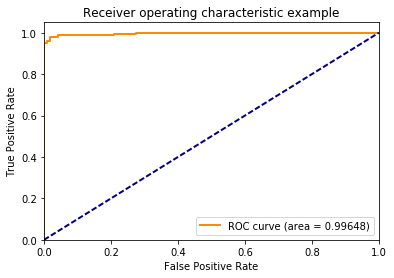

auc 0.99648


0.99648148148148141

In [399]:
#  knn based algorithm test

def eval_knn(
    sensor_type = ['rssi.a','rssi.b', ['linear_accel[0]','linear_accel[1]','linear_accel[2]']],
    n_record = 3,
    base = '01_11_01',
    normal = '^01_11',
    anomaly = '^01_1[23]',
    ms_interval = 20,
    ma_window = 3,
    n_train = 3,
    normalize = True):
    
    # recalc input
    drop_interval = int(ms_interval / 20)
    
    # get data
    dfl_b = datasets.get_data(ds, title=base, before=n_record,
                              column=sensor_type, drop_interval=drop_interval)[:n_train]
    dfl_n = datasets.get_data(ds, title=normal, before=n_record,
                              column=sensor_type, drop_interval=drop_interval)
    dfl_o = datasets.get_data(ds, title=anomaly, before=n_record,
                              column=sensor_type, drop_interval=drop_interval)

    # moving average
    dfl_b = datasets.moving_average(dfl_b, window=ma_window, min_periods=ma_window)
    dfl_n = datasets.moving_average(dfl_n, window=ma_window, min_periods=ma_window)
    dfl_o = datasets.moving_average(dfl_o, window=ma_window, min_periods=ma_window)
    
    # normalize
    if normalize == True:
        dfl_b_n = datasets.normalize_by_base_data(dfl_b, dfl_b, sensor_type)
        dfl_n_n = datasets.normalize_by_base_data(dfl_b, dfl_n, sensor_type)
        dfl_o_n = datasets.normalize_by_base_data(dfl_b, dfl_o, sensor_type)

    # get numpy array
    data_2d_b = [df.as_matrix() for df in dfl_b_n]
    data_2d_n = [df.as_matrix() for df in dfl_n_n]
    data_2d_o = [df.as_matrix() for df in dfl_o_n]

    # to list of numpy.array
    data_b = [d.ravel() for d in data_2d_b]
    data_n = [d.ravel() for d in data_2d_n]
    data_o = [d.ravel() for d in data_2d_o]

    model = knn.EstimatorKNN()
    model.fit(data_n)
    score_n = model.decision_function(data_n)
    score_o = model.decision_function(data_o)
    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o, graph=True)
    print('auc %.5f'%(auc))
    
    return auc

eval_knn()

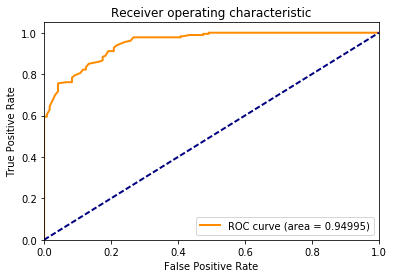

auc 0.94995


0.94995370370370369

In [462]:
# rssi based method test

def eval_rssibased(
    sensor_type = ['rssi.a','rssi.b'],
    n_record = 3,
    base = '01_11_01',
    normal = '^01_11',
    anomaly = '^01_1[23]',
    ms_interval = 20,
    ma_window = 3,
    n_train = 3,
    normalize = False):
    
    # recalc input
    drop_interval = int(ms_interval / 20)
    
    # get data
    dfl_b = datasets.get_data(ds, title=base, before=n_record,
                              column=sensor_type, drop_interval=drop_interval)[:n_train]
    dfl_n = datasets.get_data(ds, title=normal, before=n_record,
                              column=sensor_type, drop_interval=drop_interval)
    dfl_o = datasets.get_data(ds, title=anomaly, before=n_record,
                              column=sensor_type, drop_interval=drop_interval)

    # moving average
    dfl_b = datasets.moving_average(dfl_b, window=ma_window, min_periods=ma_window)
    dfl_n = datasets.moving_average(dfl_n, window=ma_window, min_periods=ma_window)
    dfl_o = datasets.moving_average(dfl_o, window=ma_window, min_periods=ma_window)

    # normalize data
    if normalize == True:
        dfl_b = datasets.normalize_by_base_data(dfl_b, dfl_b, sensor_type)
        dfl_n = datasets.normalize_by_base_data(dfl_b, dfl_n, sensor_type)
        dfl_o = datasets.normalize_by_base_data(dfl_b, dfl_o, sensor_type)
    
    # to numpy array
    data_2d_b = [df.as_matrix() for df in dfl_b]
    data_2d_n = [df.as_matrix() for df in dfl_n]
    data_2d_o = [df.as_matrix() for df in dfl_o]

    # to list of numpy.array
    data_n = [d.ravel() for d in data_2d_n]
    data_o = [d.ravel() for d in data_2d_o]

    model = rssie.EstimatorRssiBased()
    model.fit(data_n)
    score_n = model.decision_function(data_n)
    score_o = model.decision_function(data_o)
    auc = roc_auc.get_auc_from_normal_outlier(score_n, score_o, graph=True)
    print('auc %.5f'%(auc))
    
    return auc

eval_rssibased()